In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

Create the novel variables

In [3]:
n = 1727 #novel number
t = 'Odyssey_2'#novel name
s = 2 #how many rows to skip

* Get the novels from Gutenberg.
* Strip them of unwanted information.
* Tokenize the text into sentences.

In [4]:
novel = strip_headers(load_etext(n))
novel = novel.replace('\n', ' ')
novel= TextBlob(novel)
novel_sentences = novel.sentences
novel_title = t

Write the sentences to a csv file. 
-There is a bug I haven't figure out yet that requires me to write to csv twice to avoid errors.

In [5]:
for l in range(2):
    novelWriter = csv.writer(open('data/novel_'+novel_title+'.csv', 'w'), delimiter=',')
    for sentence in novel_sentences:
        novelWriter.writerow([sentence])

Read in the csv file to pandas

In [6]:
df_novel = pd.read_csv('data/novel_'+novel_title+'.csv', skiprows = s, header=None)

In [7]:
df_novel.head()

,0
0,I shall not here argue the two main points dea...
1,"The points in question are: (1) that the ""Ody..."
2,(2) That the poem was entirely written by a ve...
3,The main arguments on which I base the first o...
4,Both contentions were urged (also without rejo...


Create the wrd_length and total_char columns.

In [8]:
wrd_length = []
total_char = []
def wrd_char_counts(sentence):
    total_chars = 0
    wrd_counts = []
    for word in sentence:
        char_count = len(word)
        wrd_counts.append(char_count)
        total_chars += char_count
    total_char.append(total_chars)
    wrd_length.append(wrd_counts)

In [9]:
for l in df_novel[0]:
    sent = TextBlob(l)
    wrd_char_counts(sent.words)

In [10]:
df_novel['wrd_length'] = wrd_length
df_novel['total_char'] = total_char

In [11]:
df_novel.head()

,0,wrd_length,total_char
0,I shall not here argue the two main points dea...,"[1, 5, 3, 4, 5, 3, 3, 4, 6, 5, 4, 2, 3, 4, 4, ...",127
1,"The points in question are: (1) that the ""Ody...","[3, 6, 2, 8, 3, 1, 4, 3, 7, 3, 7, 8, 2, 3, 5, ...",363
2,(2) That the poem was entirely written by a ve...,"[1, 4, 3, 4, 3, 8, 7, 2, 1, 4, 5, 5, 3, 5, 2, ...",134
3,The main arguments on which I base the first o...,"[3, 4, 9, 2, 5, 1, 4, 3, 5, 2, 5, 8, 9, 11, 4,...",215
4,Both contentions were urged (also without rejo...,"[4, 11, 4, 5, 4, 7, 9, 2, 3, 7, 5, 3, 3, 4, 3,...",99


Create syllable count column

In [12]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [13]:
syl = []
for l in df_novel[0]:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)  

In [14]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [15]:
df_novel['syl_count'] = syl_count_arr

In [16]:
df_novel.head()

,0,wrd_length,total_char,syl_count
0,I shall not here argue the two main points dea...,"[1, 5, 3, 4, 5, 3, 3, 4, 6, 5, 4, 2, 3, 4, 4, ...",127,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, ..."
1,"The points in question are: (1) that the ""Ody...","[3, 6, 2, 8, 3, 1, 4, 3, 7, 3, 7, 8, 2, 3, 5, ...",363,"[1, 1, 1, 2, 1, 0, 1, 1, 3, 1, 2, 4, 1, 1, 1, ..."
2,(2) That the poem was entirely written by a ve...,"[1, 4, 3, 4, 3, 8, 7, 2, 1, 4, 5, 5, 3, 5, 2, ...",134,"[0, 1, 1, 1, 1, 4, 2, 1, 1, 2, 1, 2, 1, 1, 1, ..."
3,The main arguments on which I base the first o...,"[3, 4, 9, 2, 5, 1, 4, 3, 5, 2, 5, 8, 9, 11, 4,...",215,"[1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3, 1, ..."
4,Both contentions were urged (also without rejo...,"[4, 11, 4, 5, 4, 7, 9, 2, 3, 7, 5, 3, 3, 4, 3,...",99,"[1, 3, 1, 1, 2, 2, 3, 1, 1, 3, 2, 1, 1, 1, 1, ..."


In [17]:
#If novel has a lot of numbers for chapter headings.
#d = df_novel[df_novel['total_char']<=2]

Create syllable sum column

In [18]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [19]:
df_novel['syl_sum'] = syl_sum

Create sentiment column

In [20]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [21]:
df_novel['sentiment'] = df_novel[0].apply(detect_sentiment)

Write all columns to csv file

In [22]:
df_novel.to_csv('data/novel_'+novel_title+'.csv', index=False)

In [23]:
#test
df_test = pd.read_csv('data/novel_'+novel_title+'.csv')

In [24]:
df_test.head()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
0,I shall not here argue the two main points dea...,"[1, 5, 3, 4, 5, 3, 3, 4, 6, 5, 4, 2, 3, 4, 4, ...",127,[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 2 2 1 1 1...,38,0.166667
1,"The points in question are: (1) that the ""Ody...","[3, 6, 2, 8, 3, 1, 4, 3, 7, 3, 7, 8, 2, 3, 5, ...",363,[1 1 1 2 1 0 1 1 3 1 2 4 1 1 1 4 1 1 1 1 1 3 1...,129,-0.063333
2,(2) That the poem was entirely written by a ve...,"[1, 4, 3, 4, 3, 8, 7, 2, 1, 4, 5, 5, 3, 5, 2, ...",134,[0 1 1 1 1 4 2 1 1 2 1 2 1 1 1 1 1 1 1 3 1 3 2...,45,0.065000
3,The main arguments on which I base the first o...,"[3, 4, 9, 2, 5, 1, 4, 3, 5, 2, 5, 8, 9, 11, 4,...",215,[1 1 3 1 1 1 1 1 1 1 1 3 2 3 1 1 4 1 5 2 1 2 1...,70,-0.047917
4,Both contentions were urged (also without rejo...,"[4, 11, 4, 5, 4, 7, 9, 2, 3, 7, 5, 3, 3, 4, 3,...",99,[1 3 1 1 2 2 3 1 1 3 2 1 1 1 1 3 1 1 1 1 2],33,0.000000


Create cluster dataframe - remove columns that can't be used

In [25]:
df_cluster = df_novel.drop('wrd_length', 1)

In [26]:
df_cluster = df_cluster.drop('syl_count', 1)

In [27]:
df_cluster.head()

,0,total_char,syl_sum,sentiment
0,I shall not here argue the two main points dea...,127,38,0.166667
1,"The points in question are: (1) that the ""Ody...",363,129,-0.063333
2,(2) That the poem was entirely written by a ve...,134,45,0.065000
3,The main arguments on which I base the first o...,215,70,-0.047917
4,Both contentions were urged (also without rejo...,99,33,0.000000


Create 20 clusters on scaled data

In [28]:
X = df_cluster.drop(0, axis=1)

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
km = KMeans(n_clusters=20, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [31]:
df_cluster['cluster'] = km.labels_

In [32]:
df_cluster.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,65.682203,20.758475,0.256506
1,123.715962,39.349765,0.005811
2,141.543478,45.179348,0.563577
3,216.163366,68.301980,0.088271
4,68.544872,21.621795,-0.301075
5,280.523810,90.000000,0.242026
6,679.333333,219.000000,0.094490
7,51.317690,16.220217,-0.004369
8,170.832117,53.970803,-0.054693


In [33]:
centers = df_cluster.groupby('cluster').mean()

Create Scatter plot 

In [34]:
colors = np.array(['#0000ff', '#ff00ff', '#39b54a', '#ff0000', '#ffff00', '#000080', '#ff99ff', '#88d392', '#bf0000', '#b4ff33', '#0000bf', '#800080','#1d5b25', '#4d226d', '#2b6855', '#128ab2', '#6666ff', '#a381bd', '#333333','#a0d0e0'])

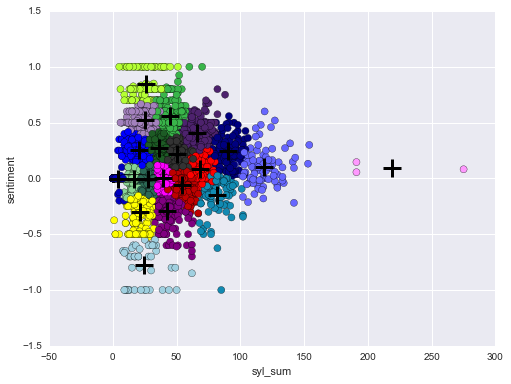

In [35]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df_cluster.syl_sum, df_cluster.sentiment, c=colors[df_cluster.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

Create 3 clusters

In [36]:
df_cluster_3 = df_cluster

In [37]:
df_cluster_3.head()

,0,total_char,syl_sum,sentiment,cluster
0,I shall not here argue the two main points dea...,127,38,0.166667,12
1,"The points in question are: (1) that the ""Ody...",363,129,-0.063333,16
2,(2) That the poem was entirely written by a ve...,134,45,0.065000,1
3,The main arguments on which I base the first o...,215,70,-0.047917,3
4,Both contentions were urged (also without rejo...,99,33,0.000000,14


In [38]:
X = df_cluster_3.drop(0, axis=1)

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [41]:
df_cluster_3['cluster'] = km.labels_

In [42]:
df_cluster_3.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,77.676201,24.598398,-0.025617
1,241.953826,76.885224,0.058178
2,126.295863,40.290468,0.413442


Create 3 Clusters with no syl_sum

In [43]:
df_cluster_no_syl = df_cluster

In [44]:
df_cluster_no_syl = df_cluster.drop('syl_sum', 1)

In [45]:
X = df_cluster_no_syl.drop(0, axis=1)

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [48]:
df_cluster_no_syl['cluster'] = km.labels_

In [49]:
df_cluster_no_syl.groupby('cluster').mean()

,total_char,sentiment
cluster,,
0,77.676201,-0.025617
1,126.234923,0.413708
2,241.890646,0.058256


Create 5 Clusters

In [50]:
df_cluster_5 = df_cluster

In [51]:
df_cluster_5.head()

,0,total_char,syl_sum,sentiment,cluster
0,I shall not here argue the two main points dea...,127,38,0.166667,2
1,"The points in question are: (1) that the ""Ody...",363,129,-0.063333,1
2,(2) That the poem was entirely written by a ve...,134,45,0.065000,0
3,The main arguments on which I base the first o...,215,70,-0.047917,1
4,Both contentions were urged (also without rejo...,99,33,0.000000,0


In [52]:
X = df_cluster_5.drop(0, axis=1)

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [54]:
km = KMeans(n_clusters=5, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [55]:
df_cluster_5['cluster'] = km.labels_

In [56]:
df_cluster_5.groupby('cluster').mean()

,total_char,syl_sum,sentiment
cluster,,,
0,124.705664,39.785515,0.422707
1,50.546335,15.900415,0.033816
2,320.947368,102.552632,0.161420
3,205.943363,65.223009,0.020862
4,111.034864,35.293367,-0.098695


Find ideal amount of clusters for novel

Find Sentiment Pattern 

20 pieces

In [57]:
df_novel['total_char'].sum()

527509

In [59]:
df_novel.tail()

,0,wrd_length,total_char,syl_count,syl_sum,sentiment
4487,{186} So practised a washerwoman as our author...,"[3, 2, 9, 1, 11, 2, 3, 9, 9, 4, 4, 2, 4, 4, 3,...",365,"[0, 1, 2, 1, 4, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, ...",115,-0.016667
4488,{187} We must suppose Dolius not yet to know t...,"[3, 2, 4, 7, 6, 3, 3, 2, 4, 4, 3, 3, 10, 3, 4,...",161,"[0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, ...",49,0.000000
4489,Dolius was probably exceptionally simple-minde...,"[6, 3, 8, 13, 13, 3, 3, 4, 3, 8]",64,"[2, 1, 3, 5, 3, 1, 1, 1, 1, 4]",22,0.666667
4490,So on Mt.,"[2, 2, 2]",6,"[1, 1, 0]",2,0.000000
4491,Eryx I was shown a man who was always called S...,"[4, 1, 3, 5, 1, 3, 3, 3, 6, 6, 5, 7, 2, 9, 2, ...",89,"[2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 4, 1, 3, 1, ...",32,0.000000


In [60]:
ratio = (df_novel['total_char'].sum()/20) - 50

In [61]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/20) - 100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w <= ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)     

In [62]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1      

df_novel['total_char'][0:196]
df_novel['total_char'][196:409]
df_novel['total_char'][409:633]
df_novel['total_char'][633:847]
df_novel['total_char'][847:1062]
df_novel['total_char'][1062:1262]
df_novel['total_char'][1262:1463]
df_novel['total_char'][1463:1667]
df_novel['total_char'][1667:1863]
df_novel['total_char'][1863:2056]
df_novel['total_char'][2056:2248]
df_novel['total_char'][2248:2473]
df_novel['total_char'][2473:2708]
df_novel['total_char'][2708:2934]
df_novel['total_char'][2934:3142]
df_novel['total_char'][3142:3346]
df_novel['total_char'][3346:3572]
df_novel['total_char'][3572:3789]
df_novel['total_char'][3789:4120]
df_novel['total_char'][4120:4489]


In [63]:
twenty_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    twenty_piece_char.append(mn)
    print mn
    st +=1   

0
196
0.121420226366
196
409
0.117087487043
409
633
0.109795536291
633
847
0.0825874544286
847
1062
0.107138453141
1062
1262
0.143915269962
1262
1463
0.140280697467
1463
1667
0.0809287766745
1667
1863
0.112120633138
1863
2056
0.0654537466228
2056
2248
0.13838209049
2248
2473
0.136372190875
2473
2708
0.105312800625
2708
2934
0.0932460522311
2934
3142
0.120243288251
3142
3346
0.10278132002
3346
3572
0.0778769402304
3572
3789
0.0901873979409
3789
4120
0.0593384579572
4120
4489
0.0217041556506


In [64]:
n = np.array(n)
twenty_piece_char = np.array(twenty_piece_char)
print twenty_piece_char

[ 0.12142023  0.11708749  0.10979554  0.08258745  0.10713845  0.14391527
  0.1402807   0.08092878  0.11212063  0.06545375  0.13838209  0.13637219
  0.1053128   0.09324605  0.12024329  0.10278132  0.07787694  0.0901874
  0.05933846  0.02170416]


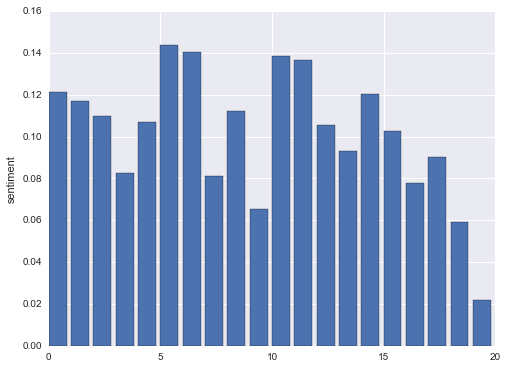

In [65]:
plt.bar(range(20), twenty_piece_char)
plt.ylabel('sentiment')
plt.show()

Create 3 piece sentiment pattern - need to fix this code for the three piece

In [ ]:
df_novel.tail()

In [66]:
t = 0
x = 0
ratio = (df_novel['total_char'].sum()/3) -100
def find_this(t, x):
    w = 0    
    sent_stop = []
    while w < ratio:
        w = df_novel['total_char'][t:x].sum()
        sent_stop.append(x)
        x += 1
    return max(sent_stop)  

In [67]:
t = 0
x = 0
start_point = []
stop_point = []
for n in range(1, 21):
    s = find_this(t, x)
    print "df_novel['total_char'][%s:%s]" %(t, s)
    start_point.append(t)
    stop_point.append(s)
    t = s
    x = s + 1  

df_novel['total_char'][0:1396]
df_novel['total_char'][1396:2789]
df_novel['total_char'][2789:4492]


KeyboardInterrupt: 

In [68]:
three_piece_char = []
st = 0
for l in start_point: 
    strt = start_point[st]
    stp = stop_point[st]
    print strt
    print stp
    mn = df_novel['sentiment'][strt:stp].mean()
    three_piece_char.append(mn)
    print mn
    st +=1

0
1396
0.118510467366
1396
2789
0.101467910798
2789
4492
0.0762730643493


In [69]:
n = np.array(n)
three_piece_char = np.array(three_piece_char)
print three_piece_char

[ 0.11851047  0.10146791  0.07627306]


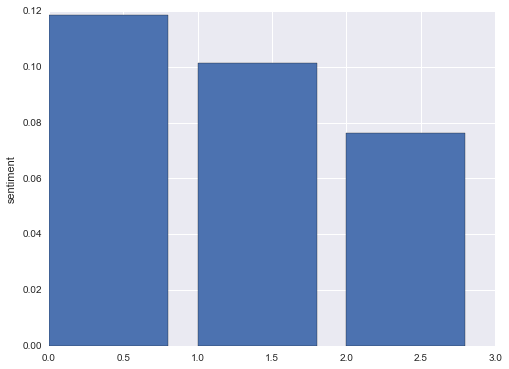

In [70]:
plt.bar(range(3), three_piece_char)
plt.ylabel('sentiment')
plt.show()

Create sentiment pattern based on ideal cluster numbers